Libraries used in the Model Given below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [2]:
df = pd.read_csv('/content/train.csv')
df.head(3)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good


In [3]:
df['Credit_Mix'].unique()


array(['Good', 'Standard', 'Bad'], dtype=object)

##Preprocessing

In [4]:

# Step 1: Shuffle and take 10,000 instances
df = df.sample(n=100000, random_state=42).reset_index(drop=True)

# Step 1: Separate the target variable and features
target_column = 'Credit_Score'


y = df[target_column]  # Target variable
# Assuming your DataFrame is called df and target column is 'target_column'


# Now, you can proceed with your neural network training using this one-hot encoded target.

X = df.drop(columns=[ 'Name','Type_of_Loan', target_column])  # Input features

# Step 2: Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Step 3: Filter categorical columns based on unique values
categorical_cols_filtered = [col for col in categorical_cols if X[col].nunique() <= 10]

# Step 4: Create a Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalize numerical columns
        ('cat', OneHotEncoder(), categorical_cols_filtered)  # One-hot encode filtered categorical columns
    ]
)

# Step 5: Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Step 6: Fit and transform the data
processed_data = pipeline.fit_transform(X)

# Step 7: Convert the result into a DataFrame
# Get feature names after one-hot encoding
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols_filtered)
columns = numerical_cols + ohe_feature_names.tolist()

# Create the final DataFrame for inputs
dfg = pd.DataFrame(processed_data, columns=columns)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)  # 85% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # 5% val, 10% test

# Display the final DataFrame and target variable
print("Processed Input Features (dfg):")
print(dfg)

print("\nTarget Variable (y):")
print(y)


Processed Input Features (dfg):
             ID  Customer_ID     Month       Age       SSN  Annual_Income  \
0      0.891048    -0.861734 -1.091089 -0.308074  1.701547      -0.185726   
1      1.045662     0.599655 -1.527525 -1.422823 -1.081280      -0.943985   
2     -1.043884    -1.207399 -1.527525  0.713779 -0.890305       2.078891   
3      0.924904    -0.904550 -0.218218  0.156405 -1.016677      -0.793695   
4      1.489229     1.288544  1.527525 -0.586761 -1.627592       1.088300   
...         ...          ...       ...       ...       ...            ...   
99995 -1.514979    -0.830493 -1.091089  1.178258  1.691475       0.824038   
99996  0.169244     0.198901  1.091089 -1.237031 -0.717141      -0.929109   
99997  0.929084    -1.295053  0.218218  0.435092 -0.931823       0.426984   
99998 -1.702248    -1.025466  0.218218  2.014319  0.975757      -0.812072   
99999 -1.184873     0.363052 -0.218218 -0.029387  0.990439      -0.818122   

       Monthly_Inhand_Salary  Num_Bank_Acco

In [5]:
y.shape

(100000,)

#1. Support Vector Classifier

In [6]:
# Step 7: Create an SVM classifier within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', SVC())])

# Step 8: Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

# Step 9: Print the cross-validation accuracy
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Step 10: Fit the model on the training data (optional if you only want to check CV scores)
model.fit(X_train, y_train)

# Step 11: (Optional) Evaluate on the validation set
val_accuracy = model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

Cross-Validation Accuracy Scores: [0.71638314 0.71778492 0.71817315]
Mean Cross-Validation Accuracy: 0.7174470713403225
Validation Accuracy: 0.7212


Test Accuracy : 0.7222


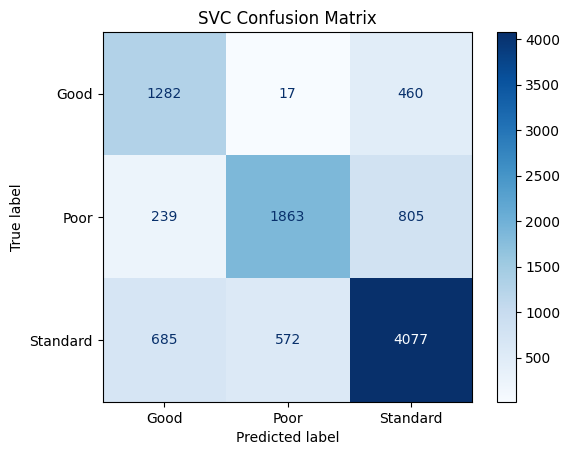

In [7]:
# Step 1: Generate predictions on the test set
y_pred = model.predict(X_test)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('SVC Confusion Matrix')
# Step 12: (Optional) Evaluate on the test set
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy :", test_accuracy)
plt.show()


#2. Logistic Regression

Cross-Validation Accuracy Scores: [0.66097268 0.6578195  0.66163131]
Mean Cross-Validation Accuracy: 0.6601411666880435
Validation Accuracy: 0.6564
Test Accuracy: 0.6638


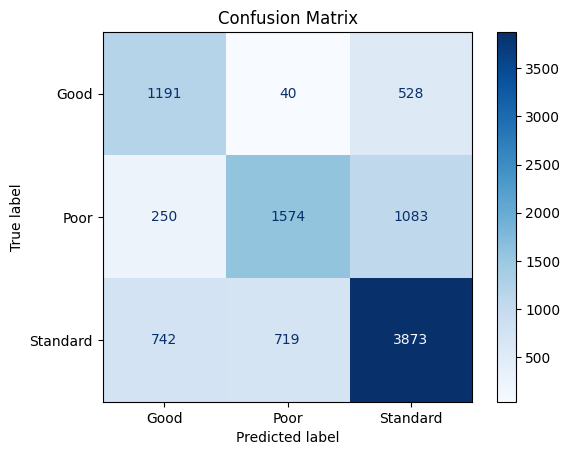

In [8]:

# Step 7: Create a Logistic Regression classifier within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=1000))])  # Increase max_iter if needed

# The rest of the code remains the same...

# Step 8: Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

# Step 9: Print the cross-validation accuracy
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Step 10: Fit the model on the training data (optional if you only want to check CV scores)
model.fit(X_train, y_train)

# Step 11: (Optional) Evaluate on the validation set
val_accuracy = model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

# Step 12: (Optional) Evaluate on the test set
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Step 13: Generate predictions on the test set for confusion matrix
y_pred = model.predict(X_test)

# Step 14: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 15: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


#3. Decision Tree Classifier

Cross-Validation Accuracy Scores: [0.74020611 0.73772633 0.72667914]
Mean Cross-Validation Accuracy: 0.7348705254636784
Validation Accuracy: 0.765
Test Accuracy: 0.7638


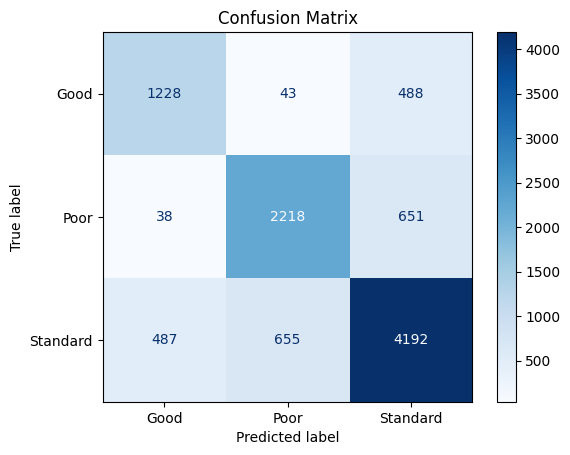

In [9]:
# Step 7: Create a Decision Tree classifier within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', DecisionTreeClassifier())])  # You can adjust parameters if needed

# The rest of the code remains the same...

# Step 8: Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

# Step 9: Print the cross-validation accuracy
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Step 10: Fit the model on the training data (optional if you only want to check CV scores)
model.fit(X_train, y_train)

# Step 11: (Optional) Evaluate on the validation set
val_accuracy = model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

# Step 12: (Optional) Evaluate on the test set
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Step 13: Generate predictions on the test set for confusion matrix
y_pred = model.predict(X_test)

# Step 14: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 15: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


#4. Random Forest Classifier

Cross-Validation Accuracy Scores: [0.81883956 0.82320968 0.81756256]
Mean Cross-Validation Accuracy: 0.8198706003652193
Validation Accuracy: 0.834
Test Accuracy: 0.8405


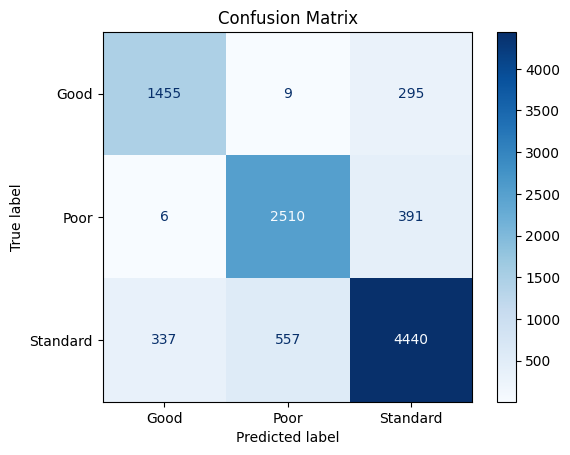

In [10]:
# Step 7: Create a Random Forest classifier within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(n_estimators=100))])  # You can adjust parameters if needed


# Step 8: Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

# Step 9: Print the cross-validation accuracy
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Step 10: Fit the model on the training data (optional if you only want to check CV scores)
model.fit(X_train, y_train)

# Step 11: (Optional) Evaluate on the validation set
val_accuracy = model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

# Step 12: (Optional) Evaluate on the test set
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Step 13: Generate predictions on the test set for confusion matrix
y_pred = model.predict(X_test)

# Step 14: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Step 15: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Feature Importance

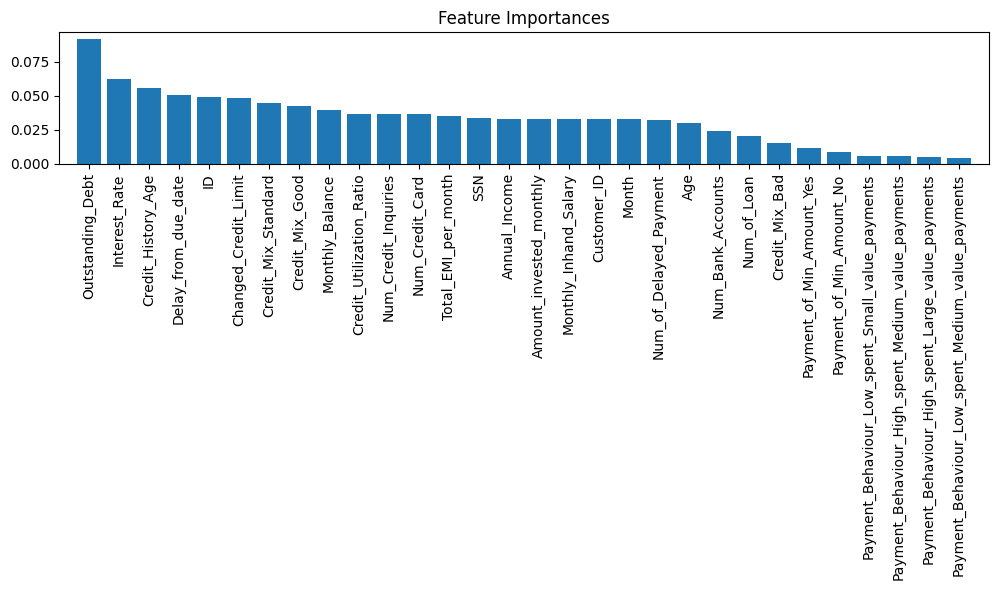

In [11]:
# Step 16: Feature Importance (from the RandomForestClassifier)
# Extract the random forest model from the pipeline
rf_model = model.named_steps['classifier']

# Get the feature importances
feature_importances = rf_model.feature_importances_

# Get the feature names from the preprocessor step
all_feature_names = numerical_cols + pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols_filtered).tolist()

# Step 17: Plot the feature importances
# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(30), feature_importances[indices[:30]], align='center')
plt.xticks(range(30), np.array(all_feature_names)[indices[:30]], rotation=90)
plt.xlim([-1, 30])
plt.tight_layout()
plt.show()

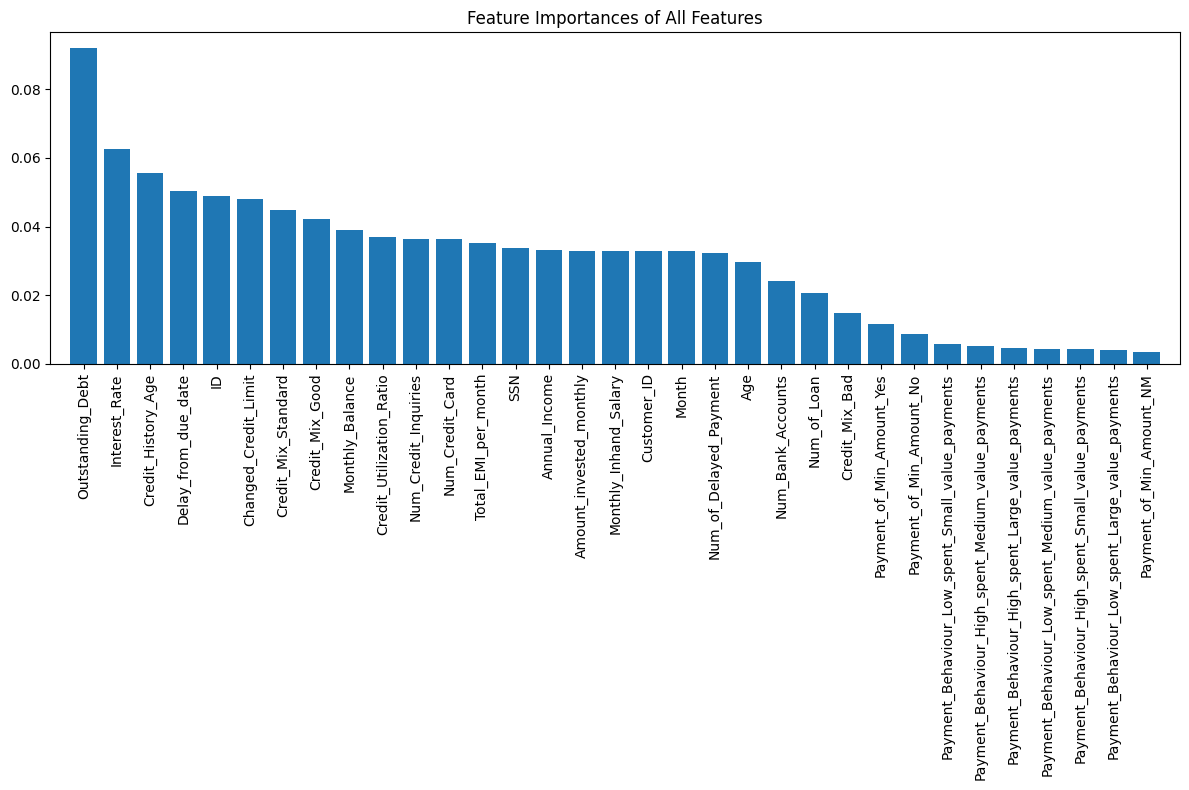

In [12]:
# Step 17: Plot the feature importances for all features
plt.figure(figsize=(12, 8))
plt.title("Feature Importances of All Features")
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
plt.xticks(range(len(feature_importances)), np.array(all_feature_names)[indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()


#5. DNN

DNN Preprocessing

In [13]:
# Step 1: Label Encode the target column
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Credit_Score'])

# Step 2: One-hot encode the labels for neural network training
y = to_categorical(y_encoded)
# Step 6: Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)  # 85% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # 5% val, 10% test
# Step 6: Fit and transform the data
processed_data = pipeline.fit_transform(X_train)
X_train = pd.DataFrame(processed_data, columns=columns)

# Step 6: Fit and transform the data
processed_data = pipeline.fit_transform(X_test)
X_test = pd.DataFrame(processed_data, columns=columns)

# Step 6: Fit and transform the data
processed_data = pipeline.fit_transform(X_val)
X_val = pd.DataFrame(processed_data, columns=columns)

In [14]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6779 - loss: 0.7004 - val_accuracy: 0.6992 - val_loss: 0.6621
Epoch 2/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7073 - loss: 0.6408 - val_accuracy: 0.6966 - val_loss: 0.6483
Epoch 3/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7148 - loss: 0.6236 - val_accuracy: 0.7104 - val_loss: 0.6343
Epoch 4/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7207 - loss: 0.6104 - val_accuracy: 0.7130 - val_loss: 0.6344
Epoch 5/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7287 - loss: 0.5963 - val_accuracy: 0.7154 - val_loss: 0.6257
Epoch 6/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7362 - loss: 0.5765 - val_accuracy: 0.7276 - val_loss: 0.6204
Epoch 7/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7422 - loss: 0.5601 - val_accuracy: 0.7294 - val_loss: 0.6050
Epoch 8/13
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7565 - loss: 0.5319 

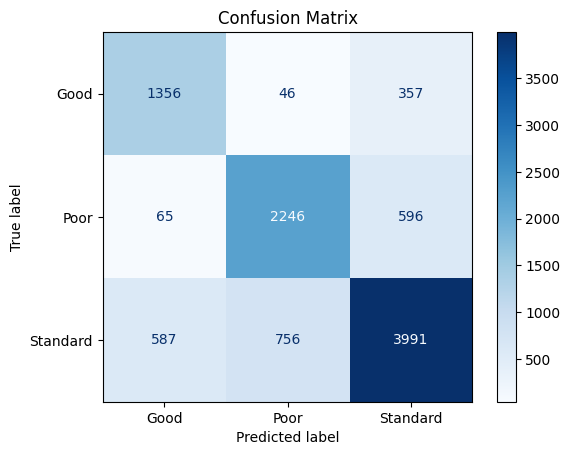

In [15]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(dfg.shape[1],)))  # Increase neurons
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

# # Step 8: Build the neural network model
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(dfg.shape[1],)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # 3 output units for the three classes (Good, Poor, Standard)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 9: Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=13, batch_size=32, validation_split=0.1, verbose=1)

# Step 10: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)


# Step 11: Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert the one-hot encoded y back to the original classes
y_true = y_test.argmax(axis=1)

# Step 12: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
# disp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred_classes, display_labels=label_encoder.classes_,sample_weight=sample, normalize='true')
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
print(f'Accuracy on test set: {accuracy * 100:.2f}%')
plt.show()


#Optimizing DNN

Epoch 1/13


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6645 - loss: 0.7193 - val_accuracy: 0.7006 - val_loss: 0.6634
Epoch 2/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7087 - loss: 0.6422 - val_accuracy: 0.7066 - val_loss: 0.6533
Epoch 3/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7108 - loss: 0.6277 - val_accuracy: 0.7132 - val_loss: 0.6339
Epoch 4/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7200 - loss: 0.6134 - val_accuracy: 0.7104 - val_loss: 0.6337
Epoch 5/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7296 - loss: 0.5909 - val_accuracy: 0.7244 - val_loss: 0.6186
Epoch 6/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7388 - loss: 0.5713 - val_accuracy: 0.7250 - val_loss: 0.6050
Epoch 7/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7515 - loss: 0.5428 - val_accuracy: 0.7312 - val_loss: 0.5952
Epoch 8/13
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7618 - loss: 0.5207 - val_accuracy: 0.7402 - 

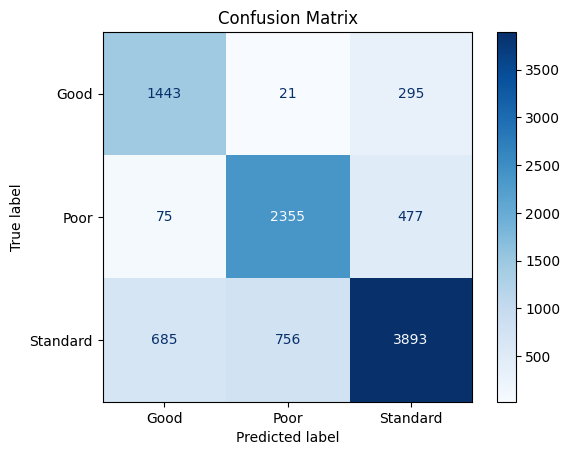

In [16]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(dfg.shape[1],)))  # Increase neurons
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

# # Step 8: Build the neural network model
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(dfg.shape[1],)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # 3 output units for the three classes (Good, Poor, Standard)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 9: Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=13, batch_size=150, validation_split=0.1, verbose=1)

# Step 10: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)


# Step 11: Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert the one-hot encoded y back to the original classes
y_true = y_test.argmax(axis=1)

# Step 12: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
# disp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred_classes, display_labels=label_encoder.classes_,sample_weight=sample, normalize='true')
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
print(f'Accuracy on test set: {accuracy * 100:.2f}%')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6735 - loss: 0.7068 - val_accuracy: 0.7000 - val_loss: 0.6551
Epoch 2/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7053 - loss: 0.6394 - val_accuracy: 0.7076 - val_loss: 0.6482
Epoch 3/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7146 - loss: 0.6200 - val_accuracy: 0.7090 - val_loss: 0.6480
Epoch 4/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7184 - loss: 0.6122 - val_accuracy: 0.7174 - val_loss: 0.6250
Epoch 5/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7309 - loss: 0.5868 - val_accuracy: 0.7214 - val_loss: 0.6244
Epoch 6/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7417 - loss: 0.5648 - val_accuracy: 0.7316 - val_loss: 0.6035
Epoch 7/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7579 - loss: 0.5334 - val_accuracy: 0.7444 - val_loss: 0.5788
Epoch 8/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7799 - loss: 0.4935 - val_

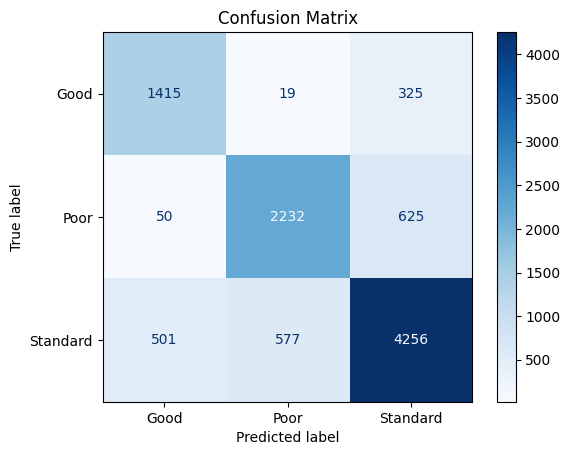

In [17]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(dfg.shape[1],)))  # Increase neurons
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

# # Step 8: Build the neural network model
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(dfg.shape[1],)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # 3 output units for the three classes (Good, Poor, Standard)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 9: Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=150, validation_split=0.1, verbose=1)

# Step 10: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)


# Step 11: Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert the one-hot encoded y back to the original classes
y_true = y_test.argmax(axis=1)

# Step 12: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
# disp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred_classes, display_labels=label_encoder.classes_,sample_weight=sample, normalize='true')
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
print(f'Accuracy on test set: {accuracy * 100:.2f}%')
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


680/680 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6739 - loss: 0.7077 - val_accuracy: 0.7026 - val_loss: 0.6571
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7091 - loss: 0.6424 - val_accuracy: 0.7040 - val_loss: 0.6521
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7150 - loss: 0.6262 - val_accuracy: 0.7136 - val_loss: 0.6330
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7222 - loss: 0.6085 - val_accuracy: 0.7266 - val_loss: 0.6273
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7301 - loss: 0.5904 - val_accuracy: 0.7138 - val_loss: 0.6283
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7393 - loss: 0.5675 - val_accuracy: 0.7260 - val_loss: 0.5996
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7616 - loss: 0.5260 - val_accuracy: 0.7436 - val_loss: 0.5927
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7871 - loss: 0.4792 - val_accurac

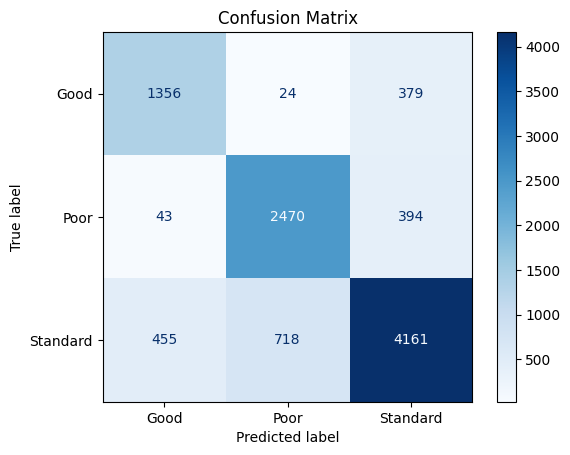

In [19]:
model = Sequential()
model.add(Dense(600, activation='relu', input_shape=(dfg.shape[1],)))  # Increase neurons
model.add(Dense(500, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

# # Step 8: Build the neural network model
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(dfg.shape[1],)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # 3 output units for the three classes (Good, Poor, Standard)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 9: Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=125, validation_split=0.1, verbose=1)

# Step 10: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)


# Step 11: Predict and calculate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert the one-hot encoded y back to the original classes
y_true = y_test.argmax(axis=1)

# Step 12: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
# disp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred_classes, display_labels=label_encoder.classes_,sample_weight=sample, normalize='true')
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
print(f'Accuracy on test set: {accuracy * 100:.2f}%')
plt.show()
